# Importing Libararies

In [16]:
import os
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras import layers

# Looking into structure of file arrangements

In [17]:
DIR = '/kaggle/input/5-flower-types-classification-dataset/flower_images/'

In [18]:
files = os.listdir(DIR)
print(files)
class_count = len(files)
print(f'There are {class_count} flower classes.')

['Orchid', 'Sunflower', 'Tulip', 'Lotus', 'Lilly']
There are 5 flower classes.


In [19]:
# Remove Non JPG images
for cls in files:
    cls_path = os.path.join(DIR, cls)
    imgs =  os.listdir(cls_path)
    img = Image.open(os.path.join(cls_path,imgs[0]))
    print(f'Class {cls} contains {len(imgs)} images images of shape {img.size}.')

Class Orchid contains 1000 images images of shape (1000, 1778).
Class Sunflower contains 1000 images images of shape (1920, 1080).
Class Tulip contains 1000 images images of shape (1920, 1200).
Class Lotus contains 1000 images images of shape (168, 300).
Class Lilly contains 1000 images images of shape (274, 184).


# Creating the data generator using ImageDataGenerator for the CNN

In [20]:
def train_val_generators():
    """
    Creates the training and validation data generators
    Returns:
        train_generator, validation_generator: tuple containing the generators
    """
    # Instantiate the ImageDataGenerator class, normalize pixel values and set arguments to augment the images 
    datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='nearest',
                                 validation_split=0.2)                               
    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = datagen.flow_from_directory(directory=DIR,
                                                        batch_size=100, 
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        subset='training',                         
                                                        target_size=(150,150))

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = datagen.flow_from_directory(directory=DIR,
                                                                  batch_size=36, 
                                                                  class_mode='categorical',
                                                                  shuffle = False,
                                                                  subset='validation', 
                                                                  target_size=(150, 150))
    return train_generator, validation_generator

In [21]:
train_generator, validation_generator = train_val_generators()

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


# Define and compile the transfer learning model

In [22]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
                                input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = False

In [23]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [24]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [25]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (class_count, activation='softmax')(x)           

# Append the dense network to the base model
model_transfer = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model_transfer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [26]:
model_transfer.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Creating a Callback class

In [27]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.99): 
            print(logs.get('val_accuracy'))
            print("\nReached 99% validation accuracy so cancelling training!")
callbacks = myCallback()

In [28]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.25,   
    patience=2, 
    min_lr=0.00001,
    verbose=2
)

In [29]:
checkpoint_path = "/kaggle/working/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model

In [30]:
history1 = model_transfer.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator, 
                    callbacks=[callbacks, reduce_lr, cp_callback]
                   )

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 1.7660 - accuracy: 0.5602
Epoch 1: saving model to /kaggle/working/cp.ckpt
40/40 [==============================] - 81s 2s/step - loss: 1.7660 - accuracy: 0.5602 - val_loss: 0.5806 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7922
Epoch 2: saving model to /kaggle/working/cp.ckpt
40/40 [==============================] - 54s 1s/step - loss: 0.5819 - accuracy: 0.7922 - val_loss: 0.5071 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.8273
Epoch 3: saving model to /kaggle/working/cp.ckpt
40/40 [==============================] - 54s 1s/step - loss: 0.4820 - accuracy: 0.8273 - val_loss: 0.4193 - val_accuracy: 0.8530 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - ETA: 0s - loss: 0.4188 - accuracy: 0.8468
Epoch 4: saving model to /kaggle/working/cp.ckp

In [31]:
print("Accuracy of the transfer_learning model is - " , model_transfer.evaluate(validation_generator)[1]*100 , "%")

28/28 [==============================] - 10s 366ms/step - loss: 0.2799 - accuracy: 0.9070
Accuracy of the transfer_learning model is -  90.70000052452087 %


#  Evaluating Accuracy and Loss for the Model

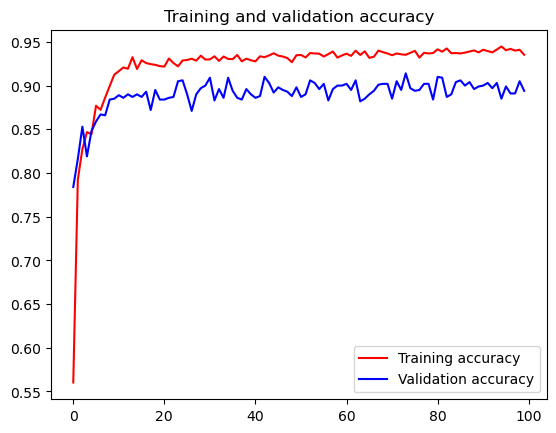

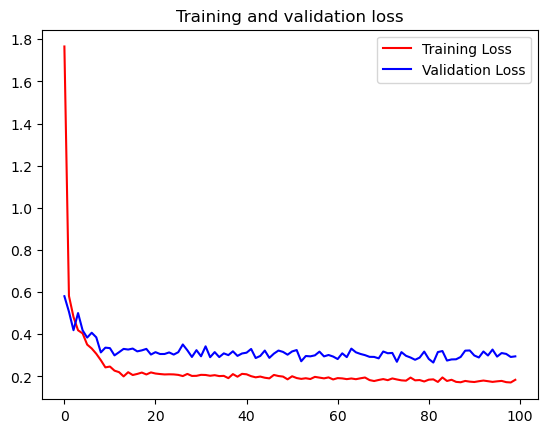

In [32]:
# Plot the chart for accuracy and loss on both training and validation
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
predictions = model_transfer.predict(validation_generator)
predictions=np.argmax(predictions,axis=-1)
print(predictions[:10])
print(validation_generator.labels[:10])

28/28 [==============================] - 11s 368ms/step
[0 0 0 0 0 0 0 0 1 2]
[0 0 0 0 0 0 0 0 0 0]


In [34]:
dict_cls = validation_generator.class_indices


In [35]:
list(dict_cls.keys())

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

#  Evaluating  Precision, Recall, F1-Score and Support for the Model

In [36]:
print(classification_report(validation_generator.labels, predictions, target_names = list(dict_cls.keys())))

              precision    recall  f1-score   support

       Lilly       0.85      0.85      0.85       200
       Lotus       0.87      0.91      0.89       200
      Orchid       0.87      0.89      0.88       200
   Sunflower       0.94      0.97      0.96       200
       Tulip       0.91      0.83      0.87       200

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



# Plotting the Confusion Matrix for the Classification

<AxesSubplot:>

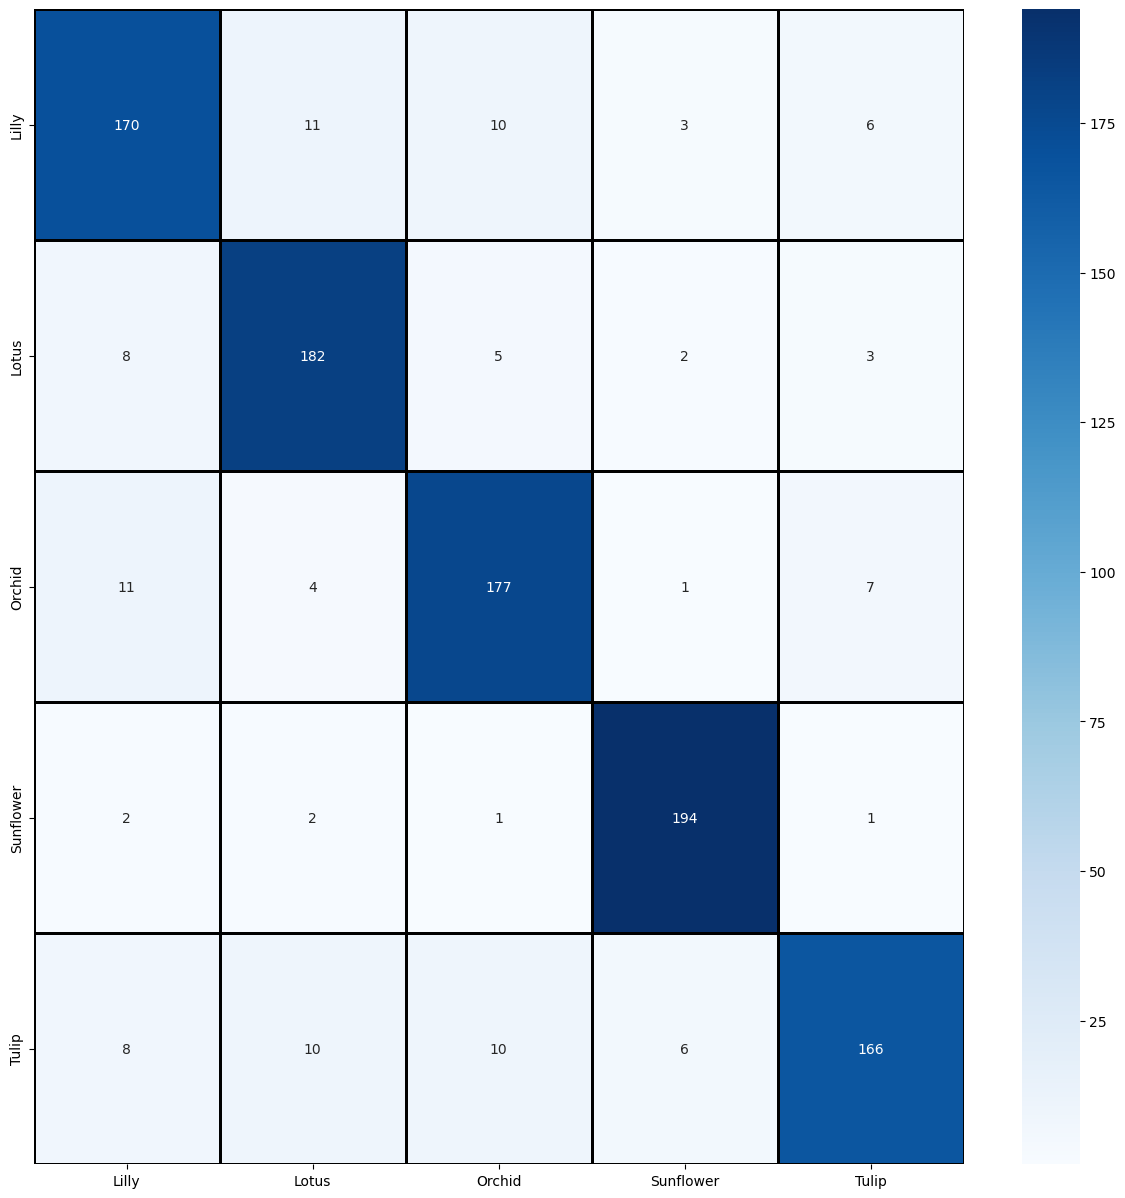

In [37]:
cm = confusion_matrix(validation_generator.labels,predictions)
cm = pd.DataFrame(cm , index = list(dict_cls.keys()) , columns = list(dict_cls.keys()))
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

# Sample Model Prediction

In [38]:
def class_name(id):
    key_list = list(dict_cls.keys())
    val_list = list(dict_cls.values())
    position = val_list.index(id)
    return key_list[position]

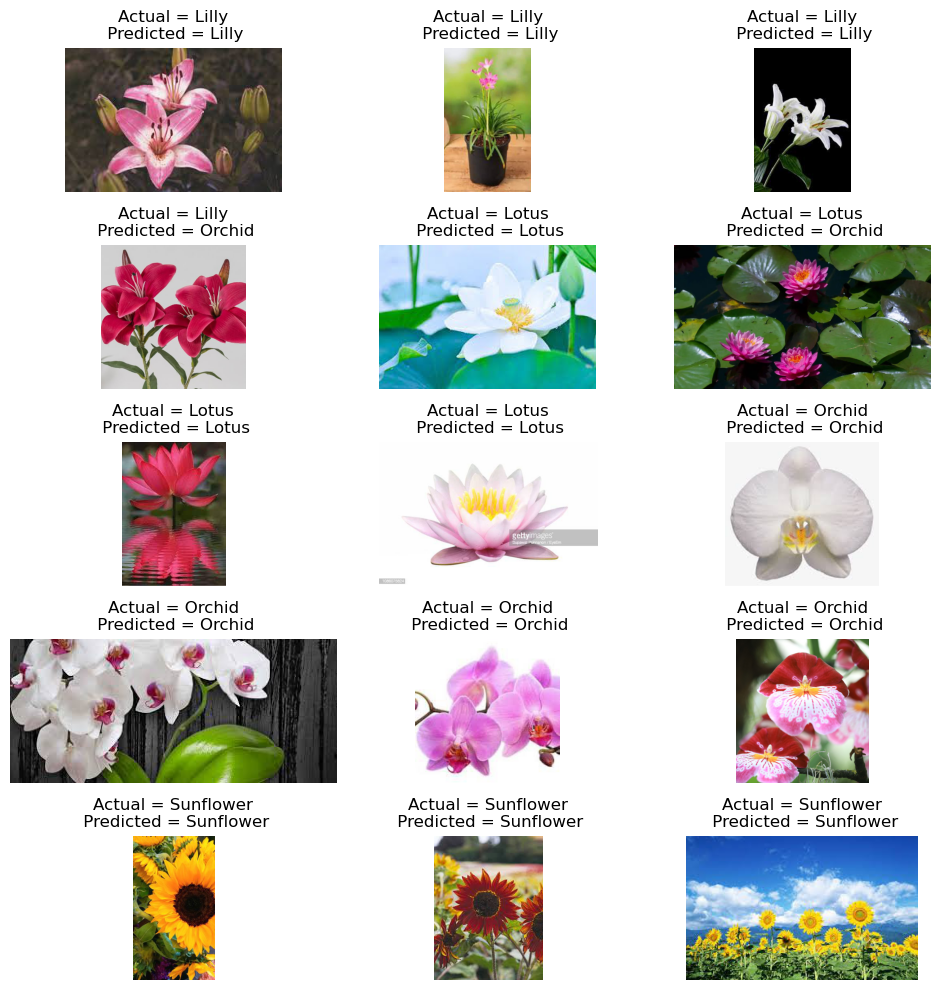

In [39]:
f, ax = plt.subplots(5,3) 
f.set_size_inches(10, 10)
k = 0
for i in range(5):
    for j in range(3):
        true_cls = validation_generator.labels[k]
        true_cls = class_name(true_cls)
        pred_cls = predictions[k]
        pred_cls = class_name(pred_cls)
        ax[i,j].set_title(f'Actual = {true_cls}\n Predicted = {pred_cls}')
        img=plt.imread(DIR+validation_generator.filenames[k])
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        k += 50
    
    plt.tight_layout() 